test Labels shape: (270, 1)
test Labels shape: (180, 1)
Train Features shape: (180, 28)
Training Accuracy: 0.99
Testing Accuracy: 0.27


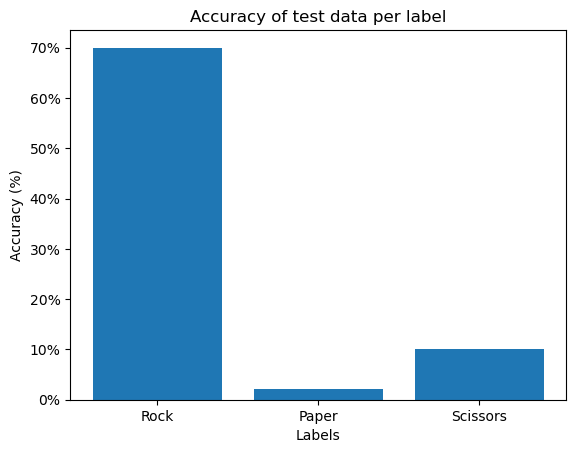

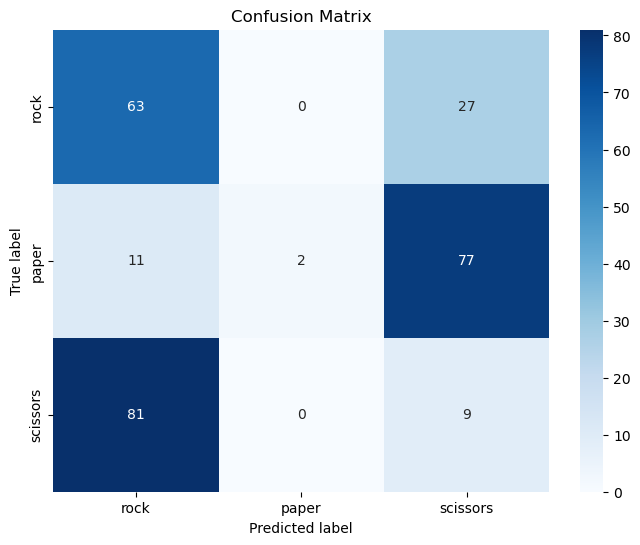

In [127]:
import numpy as np
import matplotlib.pyplot as plt #imported for plotting
import scipy.io #used for computing values
import pickle #importing to save
import ChosenFeatures # I created this list of 6 chosen featur es 
import Functions # holds various functions I mde to be used here
from sklearn.metrics import accuracy_score # using to get accuracy of data
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from ChosenFeatures import extract_features
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


#####################################################

#Test Data 
Tester = scipy.io.loadmat("DataFile/allSubjFiles.mat") #loading the correct file with the pre processed data
# data file is an array in the form of ("labels","dataChTimeTr"); stored as a dictionary
TestData = Tester['dataChTimeTr'] # specifying what colunm we are looking at. This is the third column

#Train Data
Trainer = scipy.io.loadmat("OfflineAnalysis/exampleEMGdata180trial_train.mat") # defining Trainer as the old trained data from the offline analysis assignment
TrainData = Trainer['dataChTimeTr'] #specifying what part of 3D array we are taking data from

#####################################################
print("test Labels shape:", Tester["labels"].shape)
print("test Labels shape:", Trainer["labels"].shape)

# chosen features  = RMS AR MAV VAR 
#to import chosen features I have made a file called ChosenFeatures

rps_labels = np.array(["rock", "paper", "scissors"])

test_processed = {
  "features": ChosenFeatures.extract_features(TestData),
  # flatten labels to get them to work in python
  # Since matlab indexes at 1 for some reason I subtract 1
  "labels": Tester["labels"].flatten() - 1,
  "label_names": rps_labels
}

train_processed = {
  "features": ChosenFeatures.extract_features(TrainData),
  "labels": Trainer["labels"].flatten() - 1,
  "label_names": rps_labels
}
#####################################################
# saving the data. 
Functions.save("SavedTestData.pkl", test_processed)
Functions.save("SavedTrainData.pkl", train_processed)

#####################################################
# Train Bagged Trees model to find accuracy of training data
base_classifier = DecisionTreeClassifier()  # You can customize the base classifier if needed
model = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)  # You can adjust the number of estimators

reshaped_train_features = [feature.T.reshape(180, -1) for feature in list(train_processed["features"].values())]  # Transpose and then reshape

# 2. Concatenate the features for each trial
train_features_array = np.concatenate(reshaped_train_features, axis=1) 

print("Train Features shape:", train_features_array.shape)
# Train the Bagged Trees model using the concatenated features array.
model.fit(train_features_array, train_processed["labels"])

# Predict labels for the training set
y_pred_train = model.predict(train_features_array)

# Calculate the training accuracy
training_accuracy = accuracy_score(train_processed["labels"], y_pred_train)

print(f"Training Accuracy: {training_accuracy:.2f}")


#####################################################
# Using test data
reshaped_test_features = [feature.T.reshape(270, -1) for feature in list(test_processed["features"].values())]  # Transpose and then reshape
#transposing into 270 because the shape is (270, 1)
test_features_array = np.concatenate(reshaped_test_features, axis=1) 
# concatenate the features for each trial


#below is sanity check code to make sure size is correct
#print("test features array  size", test_features_array.shape)
#print("train processed label size", train_processed["labels"].shape)
#print("test processed label size", test_processed["labels"].shape)

#print("Test Features shape:", test_features_array.shape)

# Model is trained using the Training data
model.fit(train_features_array, train_processed["labels"])

# Predict labels for the training set
y_pred_test = model.predict(test_features_array)

# Calculate the training accuracy
testing_accuracy = accuracy_score(test_processed["labels"], y_pred_test)
print(f"Testing Accuracy: {testing_accuracy:.2f}")


#####################################################
#graph accuracy of each label

# Assume y_true and y_pred are your true labels and predicted labels respectively
y_true = test_processed["labels"]
y_pred = model.predict(test_features_array)

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy for each label (mutiplied by 100 to get percentages)
label_accuracies = 100* cm.diagonal() / cm.sum(axis=1)

# Assuming your labels are numerical and continuous

labels = ["Rock", "Paper", "Scissors"]

# Plotting
plt.bar(labels, label_accuracies)
plt.xlabel('Labels')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of test data per label')
plt.xticks(labels)  # Set x-ticks to be the labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
#formatting to show percentages
plt.show()
#####################################################
#confusion matrix
#y_true and y_pred are your true labels and predicted labels respectively
y_true = test_processed["labels"]
y_pred = model.predict(test_features_array)

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Custom labels for your classes
labels = ["rock", "paper", "scissors"]

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plotting using seaborn for a more aesthetically pleasing heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#####################################################


